In [1]:
import pandas as pd
import numpy as np
import glob
import pytz
import os
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Load in Data
EVENTS_FOLDER = '../../data/bishkek_csr/03_train_ready/event_exports' 
RESPECK_FOLDER = '../../data/bishkek_csr/03_train_ready/respeck'

# --- Define relevant events ---
APNEA_EVENT_LABELS = [
    'Obstructive Apnea', 'Central Apnea', 'Mixed Apnea', 'Hypopnea'
]

# --- Main Processing Loop ---
# all_sessions_df_list = []
# event_files = glob.glob(os.path.join(EVENTS_FOLDER, '*_event_export.csv'))

# if not event_files:
#     raise FileNotFoundError(f"No event files found in '{EVENTS_FOLDER}'. Please check the path.")

# print(f"Found {len(event_files)} event files. Processing each one...")

# for event_file_path in event_files:
#     # --- 1. Setup paths and IDs ---
#     base_name = os.path.basename(event_file_path)
#     session_id = base_name.split('_event_export.csv')[0]
#     respeck_file_path = os.path.join(RESPECK_FOLDER, f'{session_id}_respeck.csv')
    
#     if not os.path.exists(respeck_file_path):
#         print(f"  - WARNING: Skipping session '{session_id}'. No matching Respeck file found.")
#         continue
        
#     print(f"  - Processing session: {session_id}")
    
#     # --- 2. Load and filter event data ---
#     df_events = pd.read_csv(event_file_path, decimal=',')
#     df_events = df_events[df_events['Event'].isin(APNEA_EVENT_LABELS)].copy()
    
#     if df_events.empty:
#         print(f"  - WARNING: Skipping session '{session_id}'. No relevant respiratory events found after filtering.")
#         continue
    
    
#     # --- 4. Load Respeck data ---
#     df_respeck = pd.read_csv(respeck_file_path)
    
#     # --- 5. Prepare both dataframes for merging ---
#     df_respeck.rename(columns={'alignedTimestamp': 'UnixTimestamp'}, inplace=True)
#     df_events.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True) # Use a temp name to avoid conflict
#     df_respeck.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True)

#     # Ensure dtypes match
#     df_events['timestamp_unix'] = df_events['timestamp_unix'].astype('int64')
#     df_respeck['timestamp_unix'] = df_respeck['timestamp_unix'].astype('int64')

#     df_respeck.sort_values('timestamp_unix', inplace=True)
#     df_events.sort_values('timestamp_unix', inplace=True)
    
#     # --- 6. Merge the data ---

#     merge_cols = ['timestamp_unix', 'Event']
    
#     df_merged = pd.merge_asof(
#         df_respeck,
#         df_events[merge_cols],
#         on='timestamp_unix',
#         direction='backward'
#     )
    
#     # --- 7. Add session ID and append to list ---
#     df_merged['SessionID'] = session_id
#     all_sessions_df_list.append(df_merged)

# # --- FINAL PROCESSING (AFTER THE LOOP) ---
# if not all_sessions_df_list:
#     raise ValueError("Processing failed. No data was loaded. Check folder paths and file names.")

# # 1. Combine all processed nights into the final DataFrame
# df = pd.concat(all_sessions_df_list, ignore_index=True)

# # 2. Rename the label column for consistency
# df.rename(columns={'Event': 'Label'}, inplace=True)

# # 3. Fill NaN values created during merge/concat
# df['Label'].fillna('Normal', inplace=True)
# print("\nPerforming one-hot encoding on 'activityType' for positional features...")
# df = pd.get_dummies(df, columns=['activityType'], prefix='activity')
# position_cols_final = [col for col in df.columns if col.startswith('pos_')]
# df[position_cols_final] = df[position_cols_final].fillna(0).astype(int)
# df['breathingSignal'] = savgol_filter(df['breathingSignal'], 51, 3)
# df['activityLevel'] = savgol_filter(df['activityLevel'], 51, 3)


# # --- Display Final Output ---
# print("\n----------------------------------------------------")
# print("Data loading, filtering, and merging complete.")
# print(f"Shape of the final combined dataset: {df.shape}")
# print("\nColumns in the final DataFrame:", df.columns.tolist())
# print("\nFinal DataFrame head:")
# print(df.head())
all_sessions_df_list = []
event_files = glob.glob(os.path.join(EVENTS_FOLDER, '*_event_export.csv'))

if not event_files:
    raise FileNotFoundError(f"No event files found in '{EVENTS_FOLDER}'. Please check the path.")

print(f"Found {len(event_files)} event files. Processing each one...")

for event_file_path in event_files:
    # --- 1. Setup paths and IDs ---
    base_name = os.path.basename(event_file_path)
    session_id = base_name.split('_event_export.csv')[0]
    respeck_file_path = os.path.join(RESPECK_FOLDER, f'{session_id}_respeck.csv')
    
    if not os.path.exists(respeck_file_path):
        print(f"  - WARNING: Skipping session '{session_id}'. No matching Respeck file found.")
        continue
    print(f"  - Processing session: {session_id}")
    
    # --- 2. Load ALL event data (NO initial filtering) ---
    df_events = pd.read_csv(event_file_path, decimal=',')
    
    # --- 3. Create the new binary 'Label' column ---
    # If the 'Event' is in our target list, label is 1 (Apnea).
    # Otherwise, for ALL other event types, label is 0 (Normal).
    df_events['Label'] = df_events['Event'].isin(APNEA_EVENT_LABELS).astype(int)
    
    # --- 4. Load Respeck data ---
    df_respeck = pd.read_csv(respeck_file_path)
    
    # --- 5. Prepare for merging (using Unix timestamps) ---
    df_respeck.rename(columns={'alignedTimestamp': 'UnixTimestamp'}, inplace=True)
    df_events.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True)
    df_respeck.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True)

    df_events['timestamp_unix'] = df_events['timestamp_unix'].astype('int64')
    df_respeck['timestamp_unix'] = df_respeck['timestamp_unix'].astype('int64')

    df_respeck.sort_values('timestamp_unix', inplace=True)
    df_events.sort_values('timestamp_unix', inplace=True)
    
    # --- 6. Merge the data (now merging the new binary 'Label' column) ---
    df_merged = pd.merge_asof(
        df_respeck,
        df_events[['timestamp_unix', 'Label']], # Only need the timestamp and our new 0/1 Label
        on='timestamp_unix',
        direction='backward'
    )
    
    # --- 7. Final cleanup ---
    # Any sensor data before the VERY FIRST event will be NaN. These are Normal.
    # So we fill any remaining NaNs with 0.
    df_merged['Label'].fillna(0, inplace=True)
    
    df_merged['SessionID'] = session_id
    all_sessions_df_list.append(df_merged)

# --- Combine all nights and perform final processing ---
if not all_sessions_df_list:
    raise ValueError("Processing failed. No data was loaded.")

df = pd.concat(all_sessions_df_list, ignore_index=True)

# Add one-hot encoded activity features (position)
df = pd.get_dummies(df, columns=['activityType'], prefix='activity')

# (Your NaN imputation and Sav-Gol filter blocks should follow here)

print("\n----------------------------------------------------")
print("Data loading with CORRECTED labeling complete.")
print(f"Final DataFrame shape: {df.shape}")
print(f"Final class distribution in raw data: \n{df['Label'].value_counts(normalize=True)}")

Found 9 event files. Processing each one...
  - Processing session: 26-04-2025


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_71924/3027637815.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Label'].fillna(0, inplace=True)


  - Processing session: 08-05-2025


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_71924/3027637815.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Label'].fillna(0, inplace=True)


  - Processing session: 05-04-2025


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_71924/3027637815.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Label'].fillna(0, inplace=True)


  - Processing session: 10-05-2025


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_71924/3027637815.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Label'].fillna(0, inplace=True)


  - Processing session: 24-04-2025


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_71924/3027637815.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Label'].fillna(0, inplace=True)


  - Processing session: 25-04-2025


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_71924/3027637815.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Label'].fillna(0, inplace=True)


  - Processing session: 16-04-2025


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_71924/3027637815.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Label'].fillna(0, inplace=True)


  - Processing session: 11-05-2025


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_71924/3027637815.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Label'].fillna(0, inplace=True)


  - Processing session: 04-04-2025


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_71924/3027637815.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Label'].fillna(0, inplace=True)



----------------------------------------------------
Data loading with CORRECTED labeling complete.
Final DataFrame shape: (4959259, 24)
Final class distribution in raw data: 
Label
0.0    0.877216
1.0    0.122784
Name: proportion, dtype: float64


In [3]:
# Windowing: Creating the time-series segments.

SAMPLING_RATE_HZ = 12.5
WINDOW_DURATION_SEC = 30
WINDOW_SIZE = int(WINDOW_DURATION_SEC * SAMPLING_RATE_HZ)

# Step size for sliding window. An 80% overlap is a good start.
OVERLAP_PERCENTAGE = 0.80
STEP_SIZE = int(WINDOW_SIZE * (1 - OVERLAP_PERCENTAGE))

# === Data Parameters ===
FEATURE_COLUMNS = [
    'breathingSignal', 
    'activityLevel',
]
LABEL_COLUMN = 'Label' 
SESSION_ID_COLUMN = 'SessionID'


TEST_NIGHTS = 2
TOTAL_NIGHTS = 9 
TEST_SIZE = TEST_NIGHTS / TOTAL_NIGHTS

RANDOM_STATE = 42
EPOCHS = 100
BATCH_SIZE = 64

In [6]:
print("\nChecking for and imputing missing values (NaNs)...")
for col in ['breathingSignal', 'activityLevel', 'x', 'y', 'z']:
    if col in df.columns:
        nan_count = df[col].isnull().sum()
        if nan_count > 0:
            print(f"  - Found {nan_count} NaNs in '{col}'. Applying forward-fill and backward-fill.")
            
            # Step 1: Forward-fill handles all NaNs except leading ones.
            df[col].ffill(inplace=True) 
            
            # Step 2: Backward-fill handles any remaining NaNs at the beginning of the file.
            df[col].bfill(inplace=True) 

# Add a final check to ensure everything is clean
final_nan_count = df[FEATURE_COLUMNS].isnull().sum().sum()
if final_nan_count > 0:
    print(f"\nWARNING: {final_nan_count} NaNs still remain in feature columns after imputation. Please investigate.")
else:
    print("\nImputation complete. No NaNs remain in feature columns.")


Checking for and imputing missing values (NaNs)...

Imputation complete. No NaNs remain in feature columns.


In [8]:
X = []
y = []
groups = [] 

# --- 2. Define the mapping from text labels to numeric labels ---
# class_labels_map = {
#     "Normal": 0,
#     # All respiratory events are mapped to 1 (Apnea event)
#     "Obstructive Apnea": 1,
#     "Central Apnea": 1,
#     "Mixed Apnea": 1,
#     "Hypopnea": 1
# }

print("Starting the windowing process...")

# --- 3. Loop through each session (night) to create windows ---
# We group by SessionID to ensure windows do not cross over between nights.
for session_id, session_df in df.groupby(SESSION_ID_COLUMN):
    for i in range(0, len(session_df) - WINDOW_SIZE, STEP_SIZE):
        
        window_df = session_df.iloc[i : i + WINDOW_SIZE]
        
        features = window_df[FEATURE_COLUMNS].values
        
        # --- CORRECTED LABELING LOGIC ---
        # The 'Label' column already contains 0s and 1s.
        # If the sum of labels in the window is > 0, it means there's at least one '1' (Apnea).
        if window_df[LABEL_COLUMN].sum() > 0:
            label = 1 # Apnea
        else:
            label = 0 # Normal
        # ------------------------------------
            
        X.append(features)
        y.append(label)
        groups.append(session_id)

# --- 4. Convert the lists into efficient NumPy arrays ---
X = np.asarray(X)
y = np.asarray(y)
groups = np.asarray(groups)

# --- 5. Print a summary of the results ---
print("\nData windowing complete.")
print("----------------------------------------------------")
print(f"Shape of X (features): {X.shape} -> (Num_Windows, Window_Size, Num_Features)")
print(f"Shape of y (labels):   {y.shape}")
print(f"Shape of groups (IDs): {groups.shape}")
print(f"Final class distribution across all windows: {Counter(y)} (0=Normal, 1=Apnea)")

Starting the windowing process...

Data windowing complete.
----------------------------------------------------
Shape of X (features): (66975, 375, 2) -> (Num_Windows, Window_Size, Num_Features)
Shape of y (labels):   (66975,)
Shape of groups (IDs): (66975,)
Final class distribution across all windows: Counter({np.int64(0): 56448, np.int64(1): 10527}) (0=Normal, 1=Apnea)


In [9]:
# Splitting dataset

unique_session_ids = np.unique(groups)
n_total_sessions = len(unique_session_ids)

print(f"Found {n_total_sessions} unique sessions (nights) in the dataset: {unique_session_ids}")

train_ids, test_ids = train_test_split(
    unique_session_ids, 
    test_size=TEST_NIGHTS, 
    random_state=RANDOM_STATE
)
print(f"\nSplitting data into training and testing sets...")
print(f"  - Sessions assigned to TRAINING set: {train_ids}")
print(f"  - Sessions assigned to TESTING set:  {test_ids}")

train_mask = np.isin(groups, train_ids)
test_mask = np.isin(groups, test_ids)

# --- 4. Apply the masks to create the final data sets ---
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

# --- 5. Verify the results ---
print("\nTrain-test split complete.")
print("----------------------------------------------------")
print(f"Total windows in training set:   {len(X_train)}")
print(f"Total windows in testing set:    {len(X_test)}")
print(f"Shape of X_train:                {X_train.shape}")
print(f"Shape of X_test:                 {X_test.shape}")
print(f"Training set class distribution: {Counter(y_train)} (0=Normal, 1=Apnea)")
print(f"Testing set class distribution:  {Counter(y_test)} (0=Normal, 1=Apnea)")

Found 9 unique sessions (nights) in the dataset: ['04-04-2025' '05-04-2025' '08-05-2025' '10-05-2025' '11-05-2025'
 '16-04-2025' '24-04-2025' '25-04-2025' '26-04-2025']

Splitting data into training and testing sets...
  - Sessions assigned to TRAINING set: ['16-04-2025' '04-04-2025' '26-04-2025' '08-05-2025' '11-05-2025'
 '10-05-2025' '24-04-2025']
  - Sessions assigned to TESTING set:  ['25-04-2025' '05-04-2025']

Train-test split complete.
----------------------------------------------------
Total windows in training set:   49699
Total windows in testing set:    17276
Shape of X_train:                (49699, 375, 2)
Shape of X_test:                 (17276, 375, 2)
Training set class distribution: Counter({np.int64(0): 47748, np.int64(1): 1951}) (0=Normal, 1=Apnea)
Testing set class distribution:  Counter({np.int64(0): 8700, np.int64(1): 8576}) (0=Normal, 1=Apnea)


In [10]:
nsamples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape((nsamples, n_timesteps * n_features))

print("Balancing the training data using SMOTE...")
print(f"  - Original training distribution: {Counter(y_train)}")

# --- 2. Initialize and apply SMOTE ---
# `random_state` ensures that the synthetic samples are the same each time you run the code.
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

print(f"  - Resampled training distribution: {Counter(y_train_resampled)}")

# --- 3. Reshape the balanced training data back to its original 3D format ---
# The model expects the data in the format (samples, timesteps, features).
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], n_timesteps, n_features))

X_train_tensor = torch.from_numpy(X_train_resampled).float()
y_train_tensor = torch.from_numpy(y_train_resampled).long() # Use .long() for class indices

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders to handle batching and shuffling
# BATCH_SIZE is from your configuration cell
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nPyTorch DataLoaders created successfully.")


Balancing the training data using SMOTE...
  - Original training distribution: Counter({np.int64(0): 47748, np.int64(1): 1951})
  - Resampled training distribution: Counter({np.int64(0): 47748, np.int64(1): 47748})

PyTorch DataLoaders created successfully.


In [11]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
print(f"Using device: {device}")

Using device: mps


In [12]:
# cell_type: "code"
class OSA_CNN(nn.Module):
    def __init__(self, n_features, n_outputs):
        super(OSA_CNN, self).__init__()
        
        # NOTE: PyTorch's Conv1d expects input shape (batch, features, timesteps)
        # Keras expects (batch, timesteps, features). We will handle this in the forward pass.
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5)
        )
        
        # The output size of the conv blocks needs to be calculated to define the linear layer
        # For an input of 375, after one MaxPool1d(2), the size becomes floor(375/2) = 187
        flattened_size = 64 * 187 # (out_channels * sequence_length_after_pooling)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 100),
            nn.ReLU(),
            nn.Linear(100, n_outputs) # Output raw logits for CrossEntropyLoss
        )

    def forward(self, x):
        # --- CRITICAL STEP: Reshape input for PyTorch Conv1d ---
        # Input x has shape (batch, timesteps, features)
        # We permute it to (batch, features, timesteps)
        x = x.permute(0, 2, 1)
        # ----------------------------------------------------
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        
        # Now pass the features to the classifier
        output = self.classifier(x)
        return output

# Instantiate the model and move it to the MPS device
n_outputs = 2 # (Normal, Apnea)
model = OSA_CNN(n_features=n_features, n_outputs=n_outputs).to(device)

print("PyTorch model created and moved to MPS device.")
model

PyTorch model created and moved to MPS device.


OSA_CNN(
  (conv_block1): Sequential(
    (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=11968, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [13]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss() # This loss function is perfect for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# --- Training Loop ---
print("Starting PyTorch model training...")
for epoch in range(EPOCHS):
    model.train() # Set the model to training mode
    running_loss = 0.0
    
    # Iterate over batches of data from the DataLoader
    for i, (inputs, labels) in enumerate(train_loader):
        # Move data to the selected device (MPS)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 1. Zero the parameter gradients
        optimizer.zero_grad()
        
        # 2. Forward pass
        outputs = model(inputs)
        
        # 3. Calculate the loss
        loss = criterion(outputs, labels)
        
        # 4. Backward pass (calculate gradients)
        loss.backward()
        
        # 5. Update the model's weights
        optimizer.step()
        
        running_loss += loss.item()

    # --- Validation ---
    model.eval() # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")

print("\nModel training complete.")

Starting PyTorch model training...
Epoch [1/100], Train Loss: 0.4999, Val Loss: 1.4105, Val Accuracy: 21.58%
Epoch [2/100], Train Loss: 0.3718, Val Loss: 1.9428, Val Accuracy: 22.71%
Epoch [3/100], Train Loss: 0.3085, Val Loss: 2.7990, Val Accuracy: 26.01%
Epoch [4/100], Train Loss: 0.2655, Val Loss: 4.1469, Val Accuracy: 28.88%
Epoch [5/100], Train Loss: 0.2328, Val Loss: 3.1648, Val Accuracy: 38.07%
Epoch [6/100], Train Loss: 0.2030, Val Loss: 3.7622, Val Accuracy: 30.58%
Epoch [7/100], Train Loss: 0.1734, Val Loss: 4.6174, Val Accuracy: 27.14%
Epoch [8/100], Train Loss: 0.1489, Val Loss: 4.7216, Val Accuracy: 35.38%
Epoch [9/100], Train Loss: 0.1243, Val Loss: 6.9547, Val Accuracy: 37.93%
Epoch [10/100], Train Loss: 0.1072, Val Loss: 5.3826, Val Accuracy: 39.94%
Epoch [11/100], Train Loss: 0.0914, Val Loss: 6.9745, Val Accuracy: 41.64%
Epoch [12/100], Train Loss: 0.0743, Val Loss: 8.9151, Val Accuracy: 42.68%
Epoch [13/100], Train Loss: 0.0646, Val Loss: 5.7063, Val Accuracy: 37.76%

Evaluating final model on the test set...

Classification Report
---------------------
              precision    recall  f1-score   support

  Normal (0)       0.49      0.87      0.62      8700
   Apnea (1)       0.34      0.07      0.11      8576

    accuracy                           0.47     17276
   macro avg       0.41      0.47      0.37     17276
weighted avg       0.41      0.47      0.37     17276

Confusion Matrix
----------------


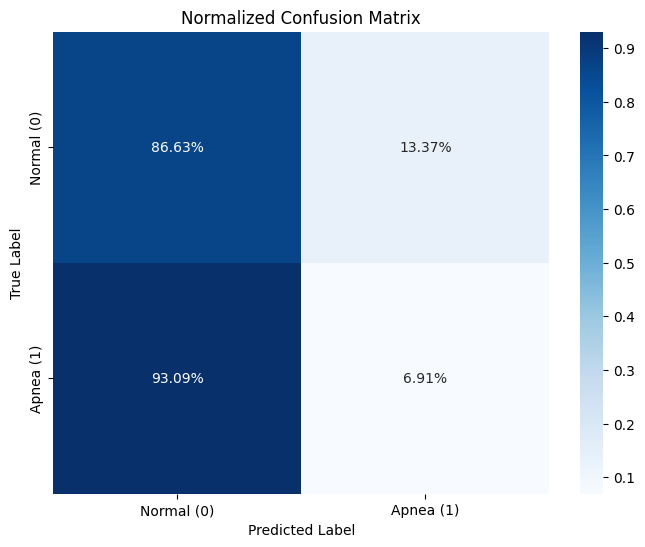

In [14]:
# cell_type: "code"
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Evaluating final model on the test set...")

model.eval() # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Classification Report and Confusion Matrix ---
print('\nClassification Report')
print('---------------------')
class_names = ['Normal (0)', 'Apnea (1)']
print(classification_report(all_labels, all_preds, target_names=class_names))

print('Confusion Matrix')
print('----------------')
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, annot=True, fmt='.2%', cmap='Blues', 
    xticklabels=class_names, yticklabels=class_names
)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()